In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime 
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.optimize import minimize
from matplotlib import rcParams
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

In [2]:
!pip install emd
import emd


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 3
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 1

In [4]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')
load = df['T (degC)']
time = df['datetime']

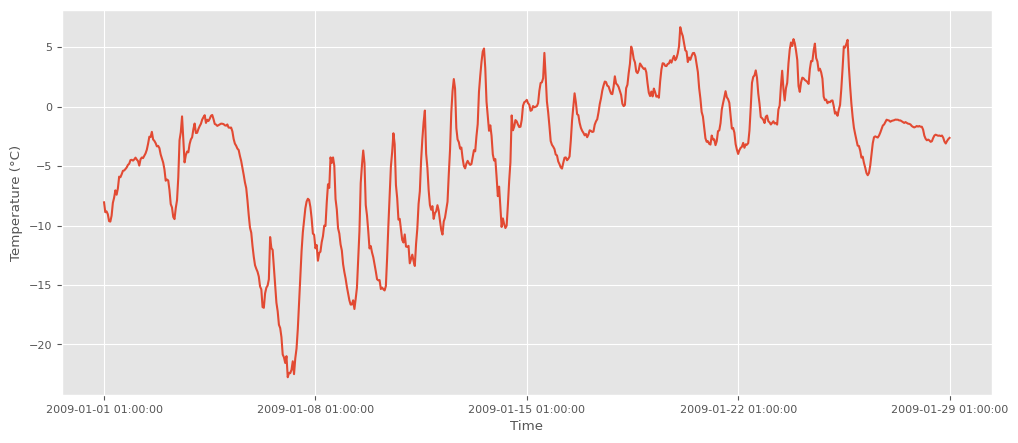

In [5]:
plt.plot(time[:673], load[:673])
plt.xticks(np.arange(0, 673, step = 168))
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.show()

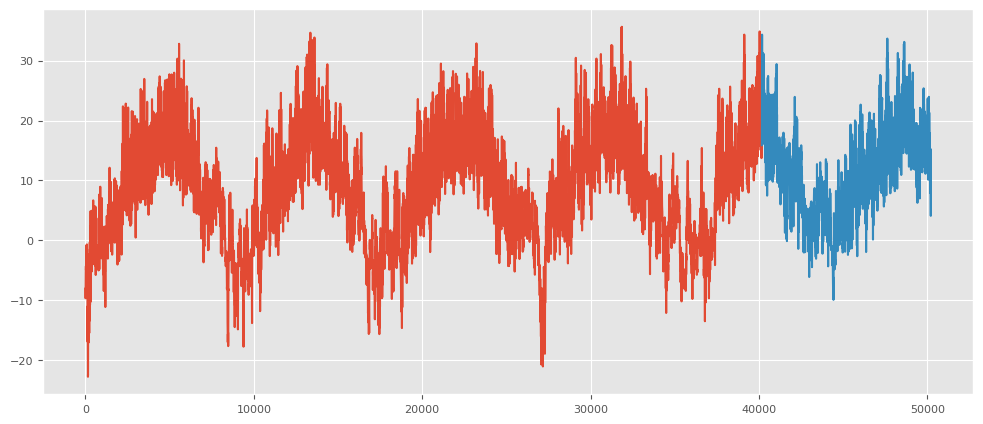

In [6]:
train = load[:int(len(load)*0.8)]
test = load[int(len(load)*0.8):]
plt.plot(train)
plt.plot(test)
plt.show()

<Figure size 1200x500 with 0 Axes>

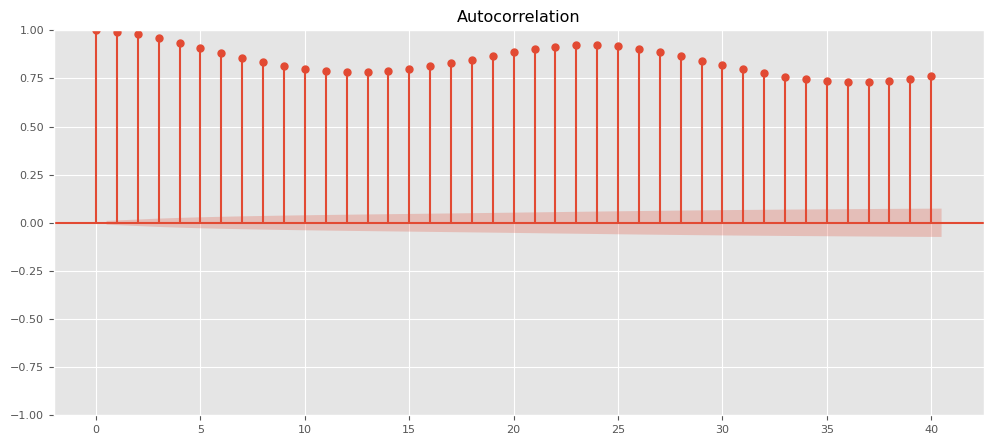

<Figure size 1200x500 with 0 Axes>

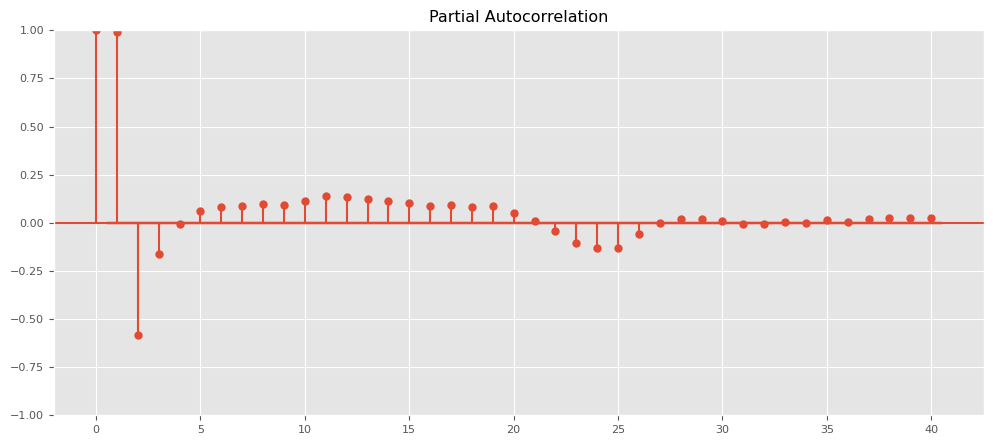

In [7]:
plt.figure()
acf_values = acf(train)
plot_acf(train, lags=40)
plt.show()

plt.figure()
pacf_values = pacf(train)
plot_pacf(train, lags=40)
plt.show()

In [8]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
t_degc = 'T (degC)'

for i in range(1,4):
    df_train["lag{}".format(i)] = df_train[t_degc].shift(i)
    df_test["lag{}".format(i)] = df_test[t_degc].shift(i)

df_train = df_train.bfill()
df_train = df_train.drop(columns = [t_degc])
df_test = df_test.bfill()
df_test = df_test.drop(columns = [t_degc])

display(df_train, df_test)

,lag1,lag2,lag3
0,-8.05,-8.05,-8.05
1,-8.05,-8.05,-8.05
2,-8.88,-8.05,-8.05
3,-8.81,-8.88,-8.05
4,-9.05,-8.81,-8.88
...,...,...,...
40174,22.40,23.72,26.45
40175,20.36,22.40,23.72
40176,19.28,20.36,22.40
40177,18.88,19.28,20.36


,lag1,lag2,lag3
40179,15.89,15.89,15.89
40180,15.89,15.89,15.89
40181,16.37,15.89,15.89
40182,18.50,16.37,15.89
40183,21.14,18.50,16.37
...,...,...,...
50219,13.17,10.36,8.01
50220,13.69,13.17,10.36
50221,14.19,13.69,13.17
50222,14.99,14.19,13.69


# Empirical M Decomposition - SVM¶

# EEMD

<Axes: xlabel='Time (samples)'>

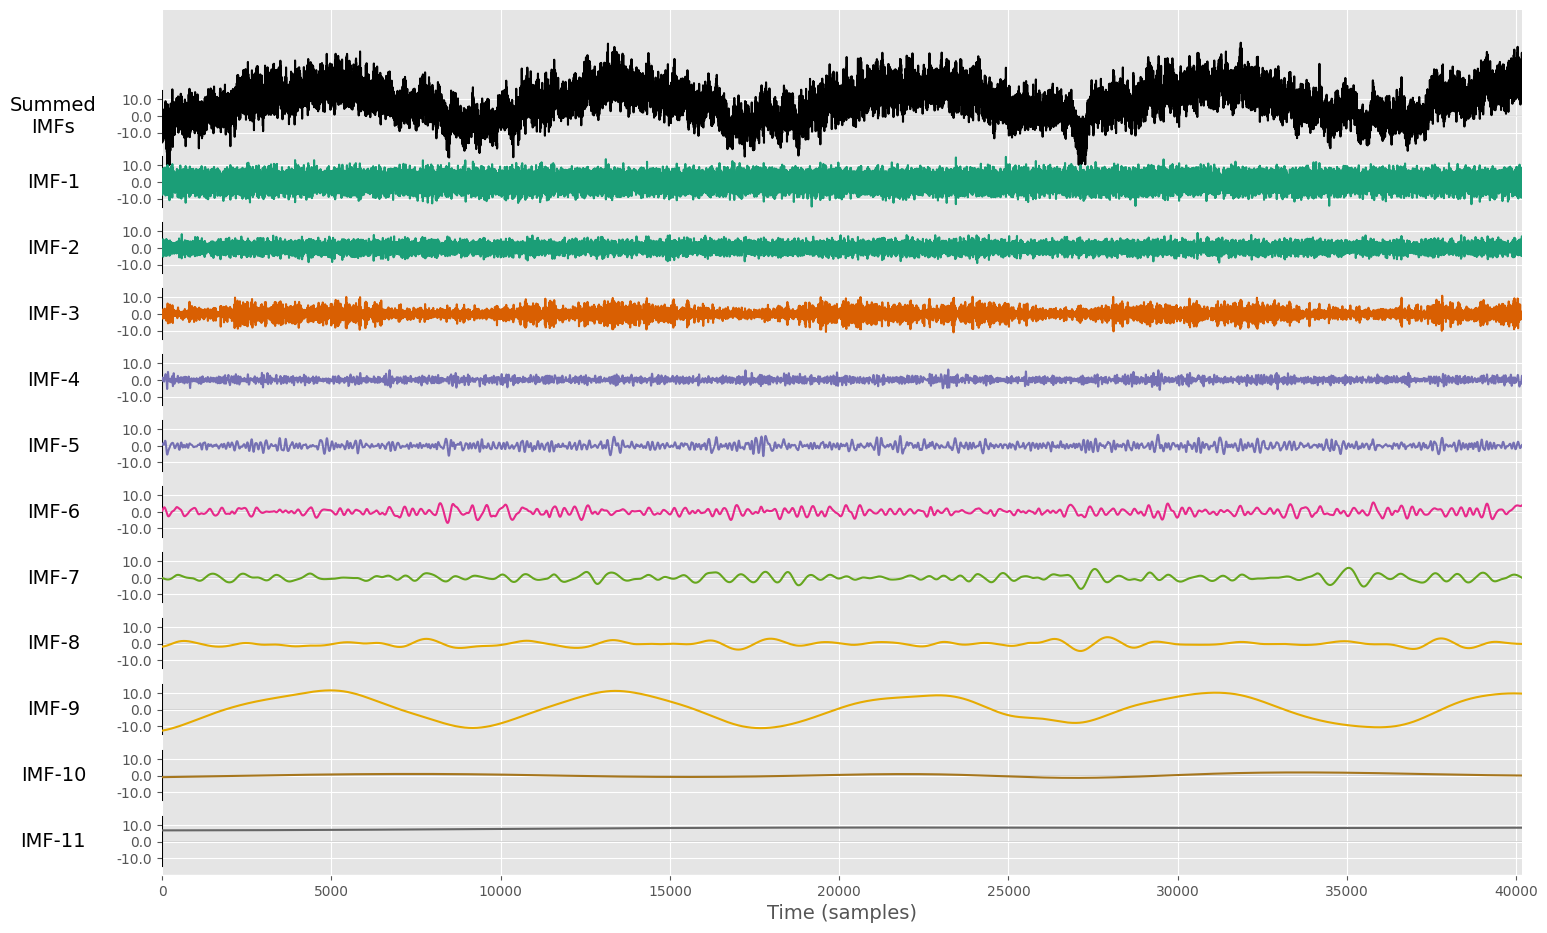

In [9]:
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

In [10]:
imf_eemd_df = pd.DataFrame(data = imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10,imf_eemd_11
0,6.383440,-2.998074,-2.721967,-0.181217,0.758959,0.678092,-0.185428,-1.790810,-12.603923,-0.927300,6.729222
1,0.100485,-2.746119,-2.386621,-0.083822,0.757655,0.719633,-0.192855,-1.788089,-12.600314,-0.926980,6.729244
2,-4.499841,-2.163252,-1.949727,0.005669,0.763239,0.761628,-0.200265,-1.785332,-12.596696,-0.926659,6.729265
3,4.326596,-1.558936,-1.475158,0.088607,0.775379,0.804037,-0.207656,-1.782540,-12.593070,-0.926339,6.729287
4,3.496876,-0.598146,-1.007302,0.166884,0.793627,0.846821,-0.215030,-1.779712,-12.589435,-0.926019,6.729309
...,...,...,...,...,...,...,...,...,...,...,...
40174,1.501087,-4.473213,-1.501211,2.384867,0.603610,3.884559,-0.029678,-0.136381,9.631484,0.060756,8.335958
40175,2.424109,-4.526035,-2.233349,2.336194,0.615003,3.902998,-0.041177,-0.136555,9.630254,0.060610,8.336010
40176,-5.854982,-3.623254,-2.765721,2.283094,0.622896,3.921831,-0.052662,-0.136722,9.629020,0.060464,8.336061
40177,7.160267,-3.552777,-2.968487,2.228802,0.627132,3.941054,-0.064133,-0.136883,9.627781,0.060318,8.336113


In [11]:
def prepare_data(series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(1, len(scaled_data)):
        X.append(scaled_data[i-1:i, 0])
        y.append(scaled_data[i, 0])
        
    return np.array(X), np.array(y), scaler

In [12]:
lstm_1 = 64
dropout = 0.2
lstm_2 = 32
dense_1 = 16
dense_2 = 1

epochs = 8
test_length = len(test)

In [13]:
# IMF 1
imf1_eemd_lstm_X, imf1_eemd_lstm_y, scaler1 = prepare_data(imf_eemd_df['imf_eemd_1'])
imf1_eemd_lstm_X = imf1_eemd_lstm_X.reshape((imf1_eemd_lstm_X.shape[0], 1, imf1_eemd_lstm_X.shape[1]))

model1 = Sequential()
model1.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf1_eemd_lstm_X.shape[1], imf1_eemd_lstm_X.shape[2])))
model1.add(Dropout(dropout))
model1.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model1.add(Dense(dense_1, activation='relu'))
model1.add(Dense(dense_2))
model1.compile(optimizer='adam', loss='mse')
model1.fit(imf1_eemd_lstm_X, imf1_eemd_lstm_y, epochs=epochs, verbose=0)
imf1_eemd_lstm_fc = model1.predict(imf1_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf1_eemd_lstm_fc = scaler1.inverse_transform(imf1_eemd_lstm_fc)

# IMF 2
imf2_eemd_lstm_X, imf2_eemd_lstm_y, scaler2 = prepare_data(imf_eemd_df['imf_eemd_2'])
imf2_eemd_lstm_X = imf2_eemd_lstm_X.reshape((imf2_eemd_lstm_X.shape[0], 1, imf2_eemd_lstm_X.shape[1]))

model2 = Sequential()
model2.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf2_eemd_lstm_X.shape[1], imf2_eemd_lstm_X.shape[2])))
model2.add(Dropout(dropout))
model2.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model2.add(Dense(dense_1, activation='relu'))
model2.add(Dense(dense_2))
model2.compile(optimizer='adam', loss='mse')
model2.fit(imf2_eemd_lstm_X, imf2_eemd_lstm_y, epochs=epochs, verbose=0)
imf2_eemd_lstm_fc = model2.predict(imf2_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf2_eemd_lstm_fc = scaler2.inverse_transform(imf2_eemd_lstm_fc)

# IMF 3
imf3_eemd_lstm_X, imf3_eemd_lstm_y, scaler3 = prepare_data(imf_eemd_df['imf_eemd_3'])
imf3_eemd_lstm_X = imf3_eemd_lstm_X.reshape((imf3_eemd_lstm_X.shape[0], 1, imf3_eemd_lstm_X.shape[1]))

model3 = Sequential()
model3.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf3_eemd_lstm_X.shape[1], imf3_eemd_lstm_X.shape[2])))
model3.add(Dropout(dropout))
model3.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model3.add(Dense(dense_1, activation='relu'))
model3.add(Dense(dense_2))
model3.compile(optimizer='adam', loss='mse')
model3.fit(imf3_eemd_lstm_X, imf3_eemd_lstm_y, epochs=epochs, verbose=0)
imf3_eemd_lstm_fc = model3.predict(imf3_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf3_eemd_lstm_fc = scaler3.inverse_transform(imf3_eemd_lstm_fc)

# # IMF 4
# imf4_eemd_lstm_X, imf4_eemd_lstm_y, scaler4 = prepare_data(imf_eemd_df['imf_eemd_4'])
# imf4_eemd_lstm_X = imf4_eemd_lstm_X.reshape((imf4_eemd_lstm_X.shape[0], 1, imf4_eemd_lstm_X.shape[1]))

# model4 = Sequential()
# model4.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf4_eemd_lstm_X.shape[1], imf4_eemd_lstm_X.shape[2])))
# model4.add(Dropout(dropout))
# model4.add(LSTM(lstm_2, activation='relu', return_sequences=False))
# model4.add(Dense(dense_1, activation='relu'))
# model4.add(Dense(dense_2))
# model4.compile(optimizer='adam', loss='mse')
# model4.fit(imf4_eemd_lstm_X, imf4_eemd_lstm_y, epochs=epochs, verbose=0)
# imf4_eemd_lstm_fc = model4.predict(imf4_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
# imf4_eemd_lstm_fc = scaler4.inverse_transform(imf4_eemd_lstm_fc)

# # IMF 5
# imf5_eemd_lstm_X, imf5_eemd_lstm_y, scaler5 = prepare_data(imf_eemd_df['imf_eemd_5'])
# imf5_eemd_lstm_X = imf5_eemd_lstm_X.reshape((imf5_eemd_lstm_X.shape[0], 1, imf5_eemd_lstm_X.shape[1]))

# model5 = Sequential()
# model5.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf5_eemd_lstm_X.shape[1], imf5_eemd_lstm_X.shape[2])))
# model5.add(Dropout(dropout))
# model5.add(LSTM(lstm_2, activation='relu', return_sequences=False))
# model5.add(Dense(dense_1, activation='relu'))
# model5.add(Dense(dense_2))
# model5.compile(optimizer='adam', loss='mse')
# model5.fit(imf5_eemd_lstm_X, imf5_eemd_lstm_y, epochs=epochs, verbose=0)
# imf5_eemd_lstm_fc = model5.predict(imf5_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
# imf5_eemd_lstm_fc = scaler5.inverse_transform(imf5_eemd_lstm_fc)

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [14]:
imf4_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf4_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_4'])
imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_test))

imf5_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf5_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_5'])
imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_test))

imf6_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_6'])
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_test))

imf7_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf7_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_7'])
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_test))

imf8_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf8_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_8'])
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_test))

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


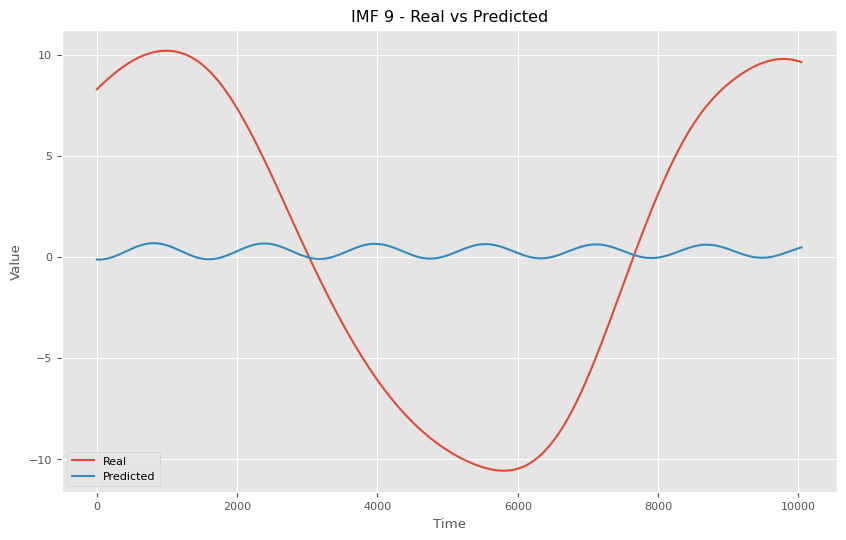

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


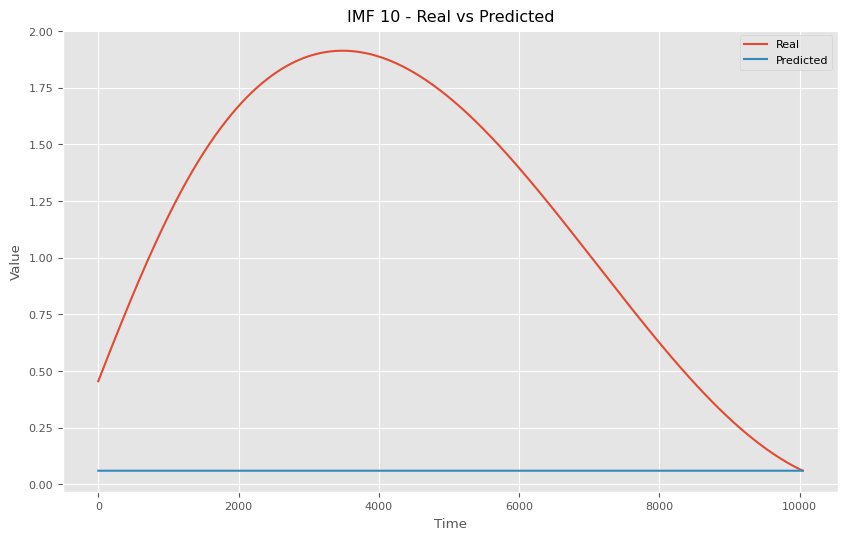

In [15]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Función para graficar los valores reales vs predichos
def plot_imf_predictions(imf_number, real_values, predicted_values):
    plt.figure(figsize=(10, 6))
    plt.plot(real_values, label='Real')
    plt.plot(predicted_values, label='Predicted')
    plt.title(f'IMF {imf_number} - Real vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Función para preparar los datos para ARIMA
def prepare_arima_data(series):
    return series.values

# IMF 9
imf9_train = prepare_arima_data(imf_eemd_df['imf_eemd_8'])
imf9_model = ARIMA(imf9_train, order=(2, 1, 0))
imf9_model_fit = imf9_model.fit()
imf9_test = prepare_arima_data(df_test)
imf9_fc = imf9_model_fit.forecast(steps=len(imf9_test))
plot_imf_predictions(9, imf_eemd_df['imf_eemd_9'].values[-len(df_test):], imf9_fc)

# IMF 10
imf10_train = prepare_arima_data(imf_eemd_df['imf_eemd_10'])
imf10_model = ARIMA(imf10_train, order=(2, 1, 0))
imf10_model_fit = imf10_model.fit()

imf10_test = prepare_arima_data(df_test)
imf10_fc = imf10_model_fit.forecast(steps=len(imf10_test))
plot_imf_predictions(10, imf_eemd_df['imf_eemd_10'].values[-len(df_test):], imf10_fc)

In [16]:
# from statsmodels.tsa.arima.model import ARIMA

# imf9_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_9'], order=(1, 1, 0)).fit()
# imf9_eemd_arima_fc = imf9_eemd_arima.forecast(steps=len(test))

# imf10_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_10'], order=(1, 1, 0)).fit()
# imf10_eemd_arima_fc = imf10_eemd_arima.forecast(steps=len(test))

In [17]:
# # plot imf10 test values vs predited values
# plt.plot(imf_eemd_df['imf_eemd_10'])
# plt.plot(imf10_eemd_arima_fc)
# plt.show()

In [18]:
imf1_eemd_lstm_fc.shape

(10045, 1)

In [19]:
imf2_eemd_lstm_fc.shape

(10045, 1)

In [20]:
imf3_eemd_lstm_fc.shape

(10045, 1)

In [21]:
imf4_eemd_SVR_fc.shape

(10045,)

In [22]:
imf8_eemd_SVR_fc.shape

(10045,)

In [23]:
imf9_fc.shape

(10045,)

In [24]:
imf10_fc.shape

(10045,)

In [25]:
imf1_eemd_lstm_fc_1 = imf1_eemd_lstm_fc.reshape(-1)
imf2_eemd_lstm_fc_2 = imf2_eemd_lstm_fc.reshape(-1)
imf3_eemd_lstm_fc_3 = imf3_eemd_lstm_fc.reshape(-1)
# imf4_eemd_lstm_fc_4 = imf4_eemd_lstm_fc.reshape(-1)
# imf5_eemd_lstm_fc_5 = imf5_eemd_lstm_fc.reshape(-1)

In [26]:
imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

imf_eemd_fc = np.sum([imf1_eemd_lstm_fc_1, imf2_eemd_lstm_fc_2, imf3_eemd_lstm_fc_3,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc, imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc, imf8_eemd_SVR_fc,imf9_fc, imf10_fc], axis = 0)

In [27]:
target_index = 'datetime'
df[target_index] = pd.to_datetime(df[target_index])
df.set_index(target_index, inplace=True)

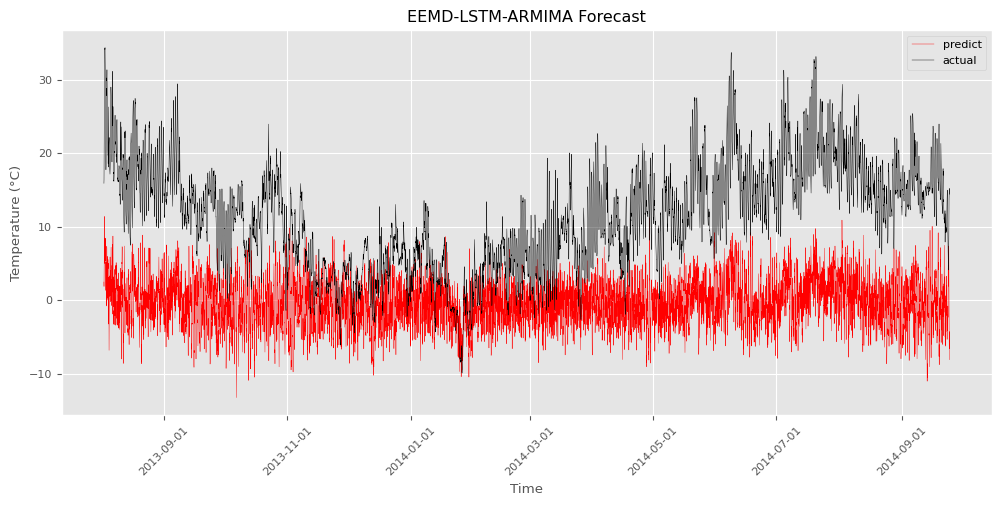

In [28]:
train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

x_label = 'Time'
y_label = 'Temperature (°C)'

plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc, label='predict', color='r', linewidth=0.3)
plt.plot(test.index, test.values, label='actual', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.title('EEMD-LSTM-ARMIMA Forecast')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

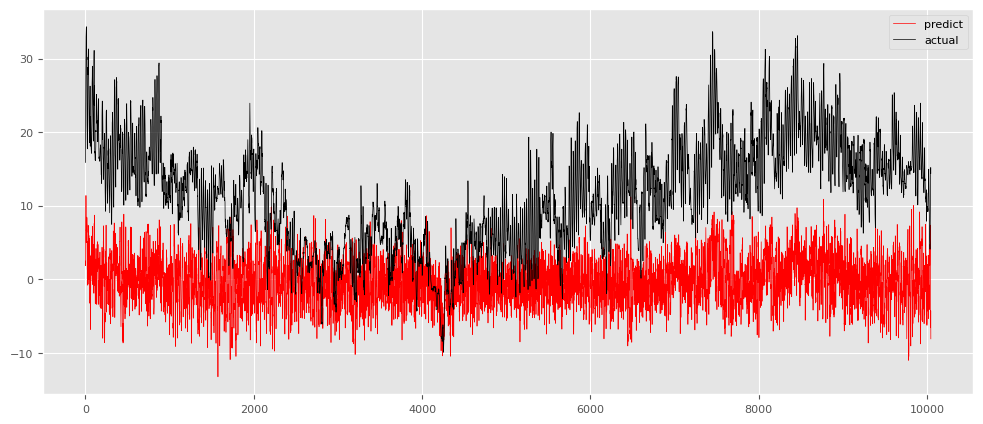

In [29]:
plt.plot(imf_eemd_fc,label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test.values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

In [30]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 189.31918388510653 
MAE = 11.883099033179633 
MAPE = 2388057473974.974


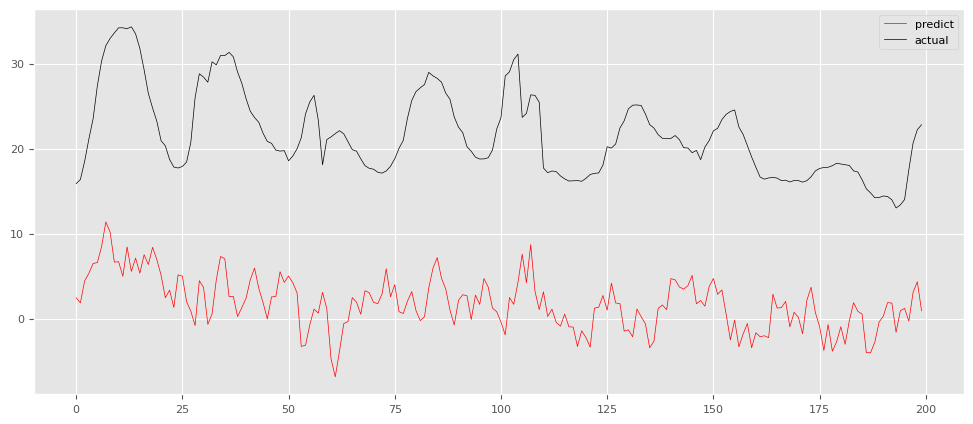

MSE = 189.31918388510653 
MAE = 11.883099033179633 
MAPE = 2388057473974.974


In [31]:
plt.plot(imf_eemd_fc[:200], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test[:200].values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [32]:
imf1_eemd_lstm_fc_train = model1.predict(imf1_eemd_lstm_X).reshape(-1, 1)
imf1_eemd_lstm_fc_train = scaler1.inverse_transform(imf1_eemd_lstm_fc_train)

imf2_eemd_lstm_fc_train = model2.predict(imf2_eemd_lstm_X).reshape(-1, 1)
imf2_eemd_lstm_fc_train = scaler2.inverse_transform(imf2_eemd_lstm_fc_train)

imf3_eemd_lstm_fc_train = model3.predict(imf3_eemd_lstm_X).reshape(-1, 1)
imf3_eemd_lstm_fc_train = scaler3.inverse_transform(imf3_eemd_lstm_fc_train)

# imf4_eemd_lstm_fc_train = model4.predict(imf4_eemd_lstm_X).reshape(-1, 1)
# imf4_eemd_lstm_fc_train = scaler4.inverse_transform(imf4_eemd_lstm_fc_train)

# imf5_eemd_lstm_fc_train = model5.predict(imf5_eemd_lstm_X).reshape(-1, 1)
# imf5_eemd_lstm_fc_train = scaler5.inverse_transform(imf5_eemd_lstm_fc_train)

1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [33]:
imf4_eemd_SVR_fc_train = imf4_eemd_SVR.predict(np.array(df_train))
imf5_eemd_SVR_fc_train = imf5_eemd_SVR.predict(np.array(df_train))
imf6_eemd_SVR_fc_train = imf6_eemd_SVR.predict(np.array(df_train))
imf7_eemd_SVR_fc_train = imf7_eemd_SVR.predict(np.array(df_train))
imf8_eemd_SVR_fc_train = imf8_eemd_SVR.predict(np.array(df_train))
# imf9_eemd_SVR_fc_train = imf9_eemd_SVR.predict(np.array(df_train))
# imf10_eemd_SVR_fc_train = imf10_eemd_SVR.predict(np.array(df_train))

In [34]:
imf9_eemd_arima_fc_train = imf9_model_fit.forecast(steps=len(train))
imf10_eemd_arima_fc_train = imf10_model_fit.forecast(steps=len(train))

In [35]:
imf1_eemd_lstm_fc_train.shape

(40178, 1)

In [36]:
imf4_eemd_SVR_fc_train.shape

(40179,)

In [37]:
imf9_eemd_arima_fc_train.shape

(40179,)

In [38]:
imf1_eemd_lstm_fc_train_train = imf1_eemd_lstm_fc_train.reshape(-1)
imf2_eemd_lstm_fc_train_train = imf2_eemd_lstm_fc_train.reshape(-1)
imf3_eemd_lstm_fc_train_train = imf3_eemd_lstm_fc_train.reshape(-1)

In [39]:
# elimina el primer registro en cada imf svr
imf4_eemd_SVR_fc_train_4 = imf4_eemd_SVR_fc_train[1:]
imf5_eemd_SVR_fc_train_5 = imf5_eemd_SVR_fc_train[1:]
imf6_eemd_SVR_fc_train_6 = imf6_eemd_SVR_fc_train[1:]
imf7_eemd_SVR_fc_train_7 = imf7_eemd_SVR_fc_train[1:]
imf8_eemd_SVR_fc_train_8 = imf8_eemd_SVR_fc_train[1:]
imf9_eemd_arima_fc_train_9 = imf9_eemd_arima_fc_train[1:]
imf10_eemd_arima_fc_train_10 = imf10_eemd_arima_fc_train[1:]

In [40]:
imf_eemd_fc_train = np.sum([imf1_eemd_lstm_fc_train_train, imf2_eemd_lstm_fc_train_train, imf3_eemd_lstm_fc_train_train,
                imf4_eemd_SVR_fc_train_4, imf5_eemd_SVR_fc_train_5, imf6_eemd_SVR_fc_train_6,
                imf7_eemd_SVR_fc_train_7, imf8_eemd_SVR_fc_train_8, imf9_eemd_arima_fc_train_9, imf10_eemd_arima_fc_train_10], axis = 0)

In [41]:
# elimina el primer registro de train
train = train[1:]

In [42]:
def dummy1(c):
    global train
    global imf_eemd_fc_train
    return mean_squared_error(train, imf_eemd_fc_train + c)

res1 = minimize(dummy1, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res1.x)

Optimization terminated successfully.
         Current function value: 51.944282
         Iterations: 44
         Function evaluations: 90
[9.58972504]


In [43]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc + res1.x[0])
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc + res1.x[0])
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc + res1.x[0])
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 57.58166201325132 
MAE = 6.250770255232612 
MAPE = 7496467228628.455


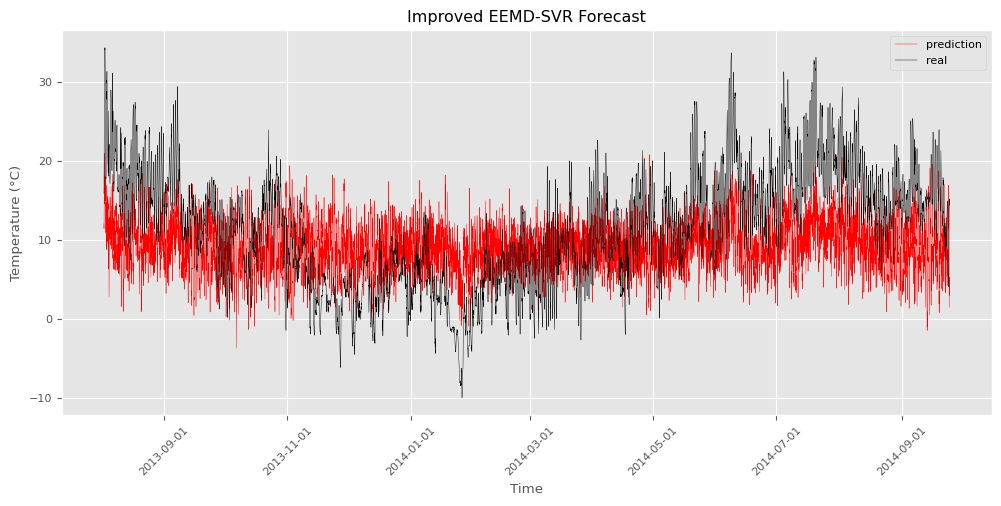

In [44]:
train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

x_label = 'Time'
y_label = 'Temperature (°C)'

plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc + res1.x[0], label='prediction', color='r', linewidth=0.3)
plt.plot(test.index, test.values, label='real', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.title('Improved EEMD-SVR Forecast')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

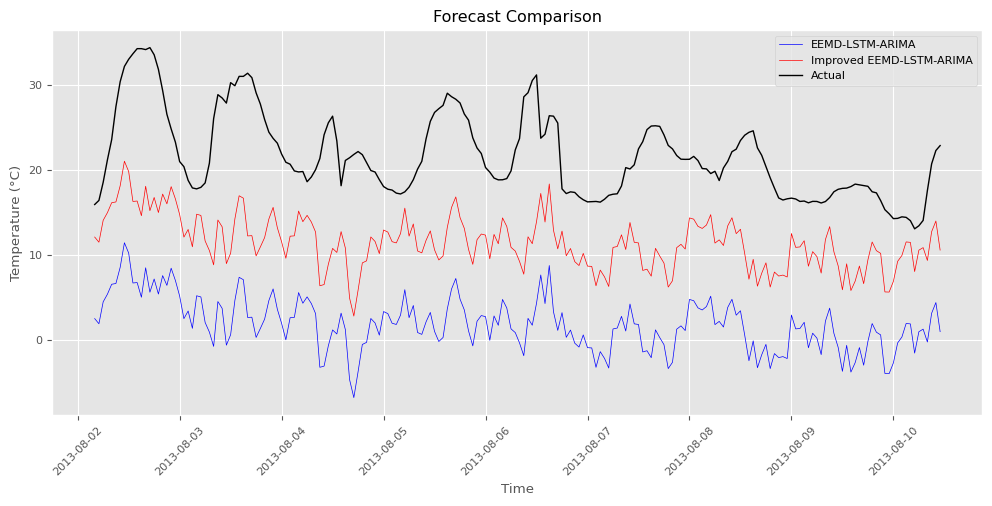

In [45]:
train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

plt.figure(figsize=(12, 5))
plt.plot(test.index[:200], imf_eemd_fc[:200], label='EEMD-LSTM-ARIMA', color='b', linewidth=0.5)
plt.plot(test.index[:200], imf_eemd_fc[:200] + res1.x[0], label='Improved EEMD-LSTM-ARIMA', color='r', linewidth=0.5)
plt.plot(test.index[:200], test.values[:200], label='Actual', color='k', linewidth=1)
plt.title('Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()